In [ ]:
#Step 1: Install Dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

#Step 2: Add environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop3"

#Step 3: Initialize Pyspark
import findspark
findspark.init()

In [ ]:
#creating spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
paths = ["/content/drive/MyDrive/Cloud Course Data/Project/CleanedDataset2/cpart1.csv", "/content/drive/MyDrive/Cloud Course Data/Project/CleanedDataset2/cpart2.csv"]
data=spark.read.option("header","true").csv(paths)
data.count()

558175

In [ ]:
data.show(5)

+-----------+--------------------+-----+--------------------+
|   video_id|        comment_text|likes|  processed_comments|
+-----------+--------------------+-----+--------------------+
|XpVt6Z1Gjjo|Logan Paul it's y...|    4|logan paul yo big...|
|XpVt6Z1Gjjo|I've been followi...|    3|ve following star...|
|XpVt6Z1Gjjo|Say hi to Kong an...|    3|say hi kong maverick|
|XpVt6Z1Gjjo| MY FAN . attendance|    3|      fan attendance|
|XpVt6Z1Gjjo|         trending 😉|    3|            trending|
+-----------+--------------------+-----+--------------------+
only showing top 5 rows



In [ ]:
data= data.filter(data.video_id.isNotNull())
data = data.filter(data.comment_text.isNotNull())
data = data.filter(data.likes.isNotNull())
data = data.filter(data.processed_comments.isNotNull())

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from textblob import TextBlob
from pyspark.sql import SparkSession
def get_polarity(text):
    return TextBlob(text).sentiment.polarity
polarity_udf = udf(get_polarity, FloatType())
data = data.withColumn("polarity", polarity_udf(data["processed_comments"]))
data.show(5)

+-----------+--------------------+-----+--------------------+--------+
|   video_id|        comment_text|likes|  processed_comments|polarity|
+-----------+--------------------+-----+--------------------+--------+
|XpVt6Z1Gjjo|Logan Paul it's y...|    4|logan paul yo big...|     0.0|
|XpVt6Z1Gjjo|I've been followi...|    3|ve following star...|     0.0|
|XpVt6Z1Gjjo|Say hi to Kong an...|    3|say hi kong maverick|     0.0|
|XpVt6Z1Gjjo| MY FAN . attendance|    3|      fan attendance|     0.0|
|XpVt6Z1Gjjo|         trending 😉|    3|            trending|     0.0|
+-----------+--------------------+-----+--------------------+--------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import rand, when, lit
data = data.sample(fraction=1.0).orderBy(rand()).drop("index")
data = data.withColumn("pol_cat", lit(0))
data = data.withColumn("pol_cat", when(data["polarity"] > 0, 0).otherwise(1))# 0 for Positive comment and 1 otherwise.
data.show(5)

+-----------+--------------------+-----+--------------------+----------+-------+
|   video_id|        comment_text|likes|  processed_comments|  polarity|pol_cat|
+-----------+--------------------+-----+--------------------+----------+-------+
|TImAMCQbwJo|       LOOKS SO GOOD|    0|           look good|       0.7|      0|
|XLNLPIRS62g|BuzzFeed is the m...|    2|buzzfeed degenera...|     0.375|      0|
|FN5n87Gj0LM|It's not really t...|    0|really execution ...|0.17222223|      0|
|R7y6fm0XTpg|Nice product plac...|    0|nice product plac...|       0.3|      0|
|z5Wo-iF6lA8|I think you guys ...|    0|      think guy quit|       0.0|      1|
+-----------+--------------------+-----+--------------------+----------+-------+
only showing top 5 rows



In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

grouped_df = data.groupBy("pol_cat").count().orderBy("pol_cat")
grouped_df.show()
pandas_df = grouped_df.toPandas()
pandas_df.plot.bar(x="pol_cat", y="count")
plt.show()

+-------+------+
|pol_cat| count|
+-------+------+
|      0|232959|
|      1|313331|
+-------+------+



In [ ]:
data.printSchema()

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df_spark = data
df_spark = df_spark.orderBy(rand()).drop("index")

(train_spark, test_spark) = df_spark.randomSplit([0.8, 0.2], seed=324)

In [ ]:
from pyspark.ml.feature import CountVectorizer, Tokenizer
# Tokenize the text data
tokenizer = Tokenizer(inputCol="processed_comments", outputCol="tokens")
train_processed = tokenizer.transform(train_spark)
test_processed = tokenizer.transform(test_spark)

In [ ]:
# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(inputCol="tokens", outputCol="features")
vectorizer_model = vectorizer.fit(train_processed)
train_vectorized = vectorizer_model.transform(train_processed)
test_vectorized = vectorizer_model.transform(test_processed)

In [ ]:
# Train a logistic regression model
lr = LogisticRegression(labelCol="pol_cat")
lr_model = lr.fit(train_vectorized)

In [ ]:
# Evaluate the model on the test set
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="pol_cat", metricName="accuracy")
train_accuracy = evaluator.evaluate(lr_model.transform(train_vectorized))
test_accuracy = evaluator.evaluate(lr_model.transform(test_vectorized))

In [ ]:
# Print the accuracies
print("Train Accuracy: {}".format(train_accuracy))
print("Test Accuracy: {}".format(test_accuracy))

Train Accuracy: 0.9930637135352619
Test Accuracy: 0.9931748088399


In [ ]:
# Show the classification reportTest
from pyspark.mllib.evaluation import MulticlassMetrics
predictions = lr_model.transform(test_vectorized)
predictions_and_labels = predictions.select(["prediction", "pol_cat"])
predictions_and_labels = predictions_and_labels.rdd.map(lambda row: (row.prediction, row.pol_cat))
metrics = MulticlassMetrics(predictions_and_labels)

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report
preds_and_labels = predictions_and_labels.collect()
y_pred = [p[0] for p in preds_and_labels]
y_true = [p[1] for p in preds_and_labels]
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     46754
           1       0.99      0.99      0.99     62823

    accuracy                           0.99    109577
   macro avg       0.99      0.99      0.99    109577
weighted avg       0.99      0.99      0.99    109577



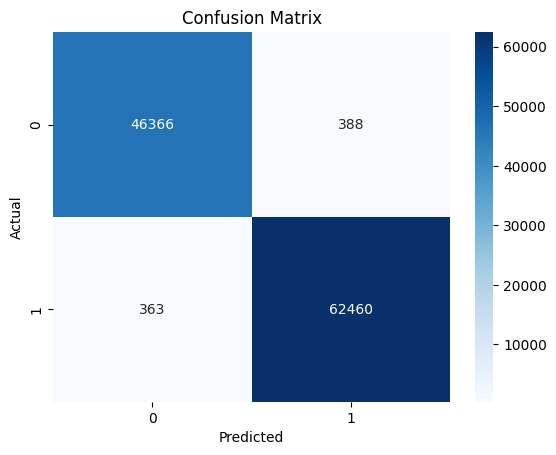

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix using seaborn
cf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()